In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Simulate some data

In [13]:
np.random.seed(666)
n_cycles = 20

df = pd.DataFrame({
    'ds': list(range(7 * n_cycles)),
    'y_constant': 2 + np.random.normal(size=7 * n_cycles, scale=0.5),
    'y_variable': 10 + np.random.normal(size=7 * n_cycles, scale=10)
})

# Convert ds to a date
df['ds_date'] = df['ds'].apply(
    lambda x: datetime.strptime('2020-01-01', '%Y-%m-%d') + timedelta(days=x)
)

# Make sure neither y is less than 0
for c in ['y_constant', 'y_variable']:
    df[c] = df[c].apply(lambda x: max(x, 0))

df.head()

,ds,y_constant,y_variable,ds_date
0,0,2.412094,3.416029,2020-01-01
1,1,2.239983,13.735839,2020-01-02
2,2,2.586734,0.000000,2020-01-03
3,3,2.454524,8.515187,2020-01-04
4,4,1.714139,0.000000,2020-01-05


### Plot each

<AxesSubplot:xlabel='ds_date', ylabel='y_constant'>

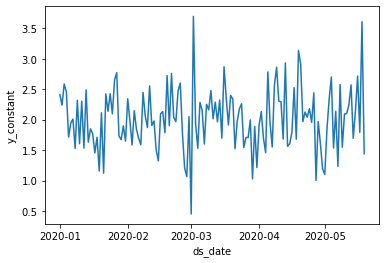

In [15]:
# Plot
sns.lineplot(data=df, x='ds_date', y='y_constant')

<AxesSubplot:xlabel='ds_date', ylabel='y_variable'>

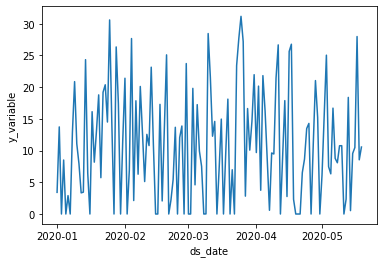

In [16]:
# Plot
sns.lineplot(data=df, x='ds_date', y='y_variable')

<AxesSubplot:xlabel='ds_date', ylabel='y_constant'>

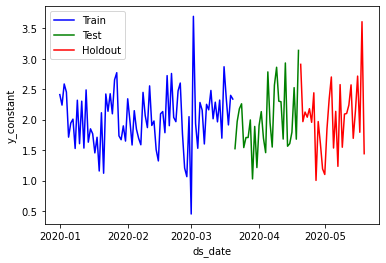

In [18]:
# Let's split into train/test/holdout
train = df[df.ds < 80]
test = df[(80 <= df.ds) & (df.ds < 110)]
holdout = df[110 <= df.ds]

# Plot
sns.lineplot(data=train, x='ds_date', y='y_constant', color='blue', label='Train')
sns.lineplot(data=test, x='ds_date', y='y_constant', color='green', label='Test')
sns.lineplot(data=holdout, x='ds_date', y='y_constant', color='red', label='Holdout')

# For y_constant, build a model and function that returns demand X days out

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

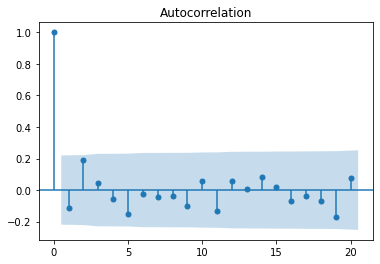

In [20]:
plot_acf(train['y_constant'])
plt.show()

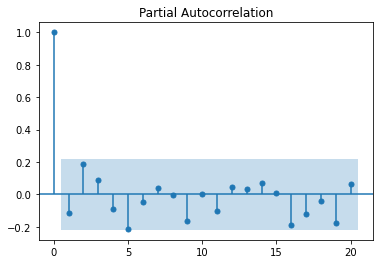

In [21]:
plot_pacf(train['y_constant'])
plt.show()

In [22]:
ns_ar = [0, 1, 2]
ns_i = [0, 1, 2]
ns_ma = [0, 1, 2]

# No apparent seasonality

In [24]:
from itertools import product

search_again = True

if search_again:
    hp_sets = list(product(ns_ar, ns_i, ns_ma))
else:
    hp_sets = [(3, 0, 3, 1, 1, 1)]

len(hp_sets)

27

In [28]:
from statsmodels.tsa.arima.model import ARIMA
import sys

arima_models = []
for _ns_ar, _ns_i, _ns_ma in hp_sets:
    # Print status
    print(f'Fitting ({_ns_ar}, {_ns_i}, {_ns_ma})')
    
    # Initialize gbm
    try:
        arima = ARIMA(
            train['y_constant'],
            order=(_ns_ar, _ns_i, _ns_ma),
        ).fit()
    except Exception as inst:
        print(f'    Unexpected Error: {inst}, {sys.exc_info()[0]}')
        continue

    # Save the score means and standard deviations
    arima_models += [
        ((_ns_ar, _ns_i, _ns_ma), arima)
    ]
    
    del arima, _ns_ar, _ns_i, _ns_ma

Fitting (0, 0, 0)
Fitting (0, 0, 1)
Fitting (0, 0, 2)
Fitting (0, 1, 0)
Fitting (0, 1, 1)
Fitting (0, 1, 2)
Fitting (0, 2, 0)
Fitting (0, 2, 1)


C:\Users\Kenneth\Miniconda3\envs\ts_1\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fitting (0, 2, 2)
Fitting (1, 0, 0)
Fitting (1, 0, 1)
Fitting (1, 0, 2)
Fitting (1, 1, 0)
Fitting (1, 1, 1)
Fitting (1, 1, 2)
Fitting (1, 2, 0)
Fitting (1, 2, 1)
Fitting (1, 2, 2)


C:\Users\Kenneth\Miniconda3\envs\ts_1\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Fitting (2, 0, 0)
Fitting (2, 0, 1)
Fitting (2, 0, 2)
Fitting (2, 1, 0)
Fitting (2, 1, 1)
Fitting (2, 1, 2)


C:\Users\Kenneth\Miniconda3\envs\ts_1\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Fitting (2, 2, 0)
Fitting (2, 2, 1)
Fitting (2, 2, 2)


C:\Users\Kenneth\Miniconda3\envs\ts_1\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [31]:
# Get test set MAE
arima_models_maes = []
for hps, _arima_model in arima_models:
    # Print status
    print(f'Forecasting {hps}')
    
    # Forecast
    _fc = _arima_model.forecast(steps=test.shape[0])
    
    # Get MAE
    _mae = abs(_fc.subtract(test['y_constant'])).mean()

    # Save the score means and standard deviations
    arima_models_maes += [
        (hps, _arima_model, _mae)
    ]
    
    del hps, _arima_model, _mae, _fc

Forecasting (0, 0, 0)
Forecasting (0, 0, 1)
Forecasting (0, 0, 2)
Forecasting (0, 1, 0)
Forecasting (0, 1, 1)
Forecasting (0, 1, 2)
Forecasting (0, 2, 0)
Forecasting (0, 2, 1)
Forecasting (0, 2, 2)
Forecasting (1, 0, 0)
Forecasting (1, 0, 1)
Forecasting (1, 0, 2)
Forecasting (1, 1, 0)
Forecasting (1, 1, 1)
Forecasting (1, 1, 2)
Forecasting (1, 2, 0)
Forecasting (1, 2, 1)
Forecasting (1, 2, 2)
Forecasting (2, 0, 0)
Forecasting (2, 0, 1)
Forecasting (2, 0, 2)
Forecasting (2, 1, 0)
Forecasting (2, 1, 1)
Forecasting (2, 1, 2)
Forecasting (2, 2, 0)
Forecasting (2, 2, 1)
Forecasting (2, 2, 2)


In [32]:
# Get the model with the minimum MAE
best_arima_by_mae = [
    x for x in arima_models_maes
    if x[2] == min([y[2] for y in arima_models_maes])
][0]

# Summarize model
best_arima_by_mae[1].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             y_constant   No. Observations:                   80
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 -55.662
Date:                Wed, 11 Nov 2020   AIC                            121.325
Time:                        20:14:16   BIC                            133.172
Sample:                             0   HQIC                           126.071
                                 - 80                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0101      0.269     -3.758      0.000      -1.537      -0.483
ar.L2         -0.0452      0.136     -0.333      0.739      -0.311       0.221
ma.L1         -0.0710      1.122     -0.063      0.950      -2.269       2.127
ma.L2         -0.9257      1.011     -0.915      0.360      -2.907       1.056
sigma2         0.2263      0.238      0.952      0.341      -0.240       0.692
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 3.35
Prob(Q):                              1.00   Prob(JB):                         0.19
Heteroskedasticity (H):               1.65   Skew:                            -0.03
Prob(H) (two-sided):                  0.21   Kurtosis:                         4.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='ds_date', ylabel='y_constant'>

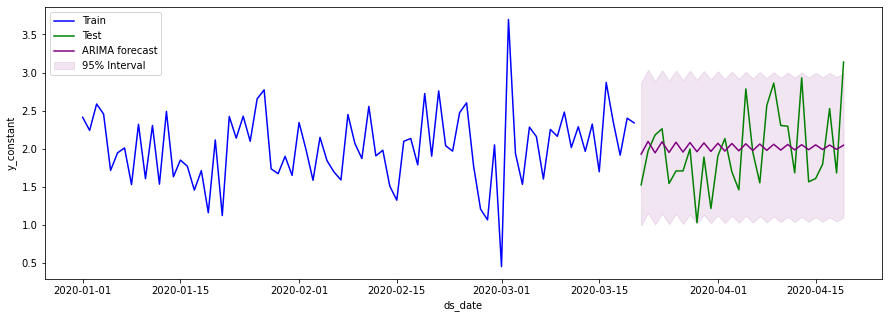

In [40]:
# Plot with prediction intervals
best_arima_by_mae_fc = best_arima_by_mae[1].get_forecast(steps=test.shape[0]).summary_frame(alpha=0.05)
best_arima_by_mae_fc['ds'] = best_arima_by_mae_fc.index
# Convert ds to a date
best_arima_by_mae_fc['ds_date'] = best_arima_by_mae_fc['ds'].apply(
    lambda x: datetime.strptime('2020-01-01', '%Y-%m-%d') + timedelta(days=x)
)

plt.figure(figsize=(15, 5))
sns.lineplot(data=train, x='ds_date', y='y_constant', color='blue', label='Train')
sns.lineplot(data=test, x='ds_date', y='y_constant', color='green', label='Test')
plt.fill_between(
    x=best_arima_by_mae_fc['ds_date'],
    y1=best_arima_by_mae_fc['mean_ci_lower'],
    y2=best_arima_by_mae_fc['mean_ci_upper'],
    color='purple',
    label='95% Interval',
    alpha=0.1
)
sns.lineplot(data=best_arima_by_mae_fc, x='ds_date', y='mean', color='purple', label='ARIMA forecast')

In [100]:
# Visualize forecasts and SE
best_arima_by_mae_fc.head()

y_constant,mean,mean_se,mean_ci_lower,mean_ci_upper,ds,ds_date
80,1.928327,0.478328,0.990822,2.865832,80,2020-03-21
81,2.095980,0.479477,1.156221,3.035738,81,2020-03-22
82,1.945184,0.480041,1.004322,2.886047,82,2020-03-23
83,2.089930,0.480137,1.148878,3.030983,83,2020-03-24
84,1.950533,0.480594,1.008587,2.892479,84,2020-03-25


In [84]:
# So, for practical purposes, we can say the mean demand is 2.  How does this translate into profit for different costs/prices?
static_mean = 2
cost = 1
price = 1.1

def get_profit(demand, x):
    revenue = (price - cost) * min(
        demand,
        float(test.loc[test.ds_date == x, 'y_constant'])
    )
    loss = cost * (demand - min(
        demand,
        float(test.loc[test.ds_date == x, 'y_constant'])
    ))
    return revenue - loss

daily_profits = [get_profit(static_mean, i) for i in test['ds_date']]
daily_profits

[-0.32273572447813614,
 0.16860785417196741,
 0.20000000000000018,
 0.20000000000000018,
 -0.3026774429318443,
 -0.12172211269487848,
 -0.12115803946771322,
 0.19605010561001252,
 -0.8686316329125958,
 0.07888874801381265,
 -0.6637846945276713,
 0.09755318351110093,
 0.20000000000000018,
 -0.13501350235226303,
 -0.39444781773625825,
 0.20000000000000018,
 0.14965007987020243,
 -0.2933124847449038,
 0.20000000000000018,
 0.20000000000000018,
 0.20000000000000018,
 0.20000000000000018,
 -0.14922048548272437,
 0.20000000000000018,
 -0.27839678524093064,
 -0.23148456976821893,
 -0.02423863680842203,
 0.20000000000000018,
 -0.15104768048184192,
 0.20000000000000018]

In [85]:
# Total profit
sum(daily_profits)

-1.167121638451304

<AxesSubplot:>

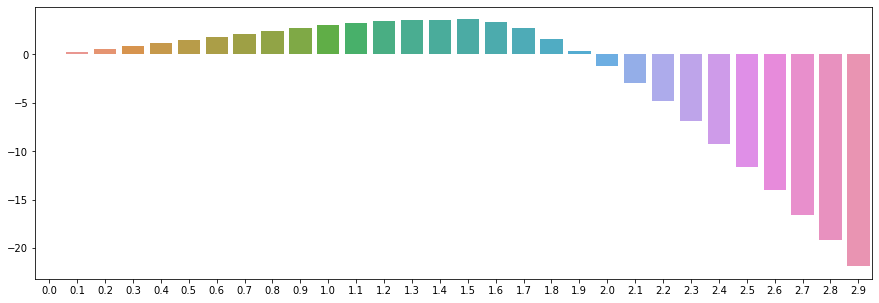

In [92]:
# Overall, we lose money!  Let's simulate a variety of stocking approaches before working out the "best" solution
mesh = np.arange(start=0, stop=3, step=0.1)

profits = []
for m in mesh:
    tmp_p = [get_profit(m, i) for i in test['ds_date']]
    profits.append(sum(tmp_p))

plt.figure(figsize=(15, 5))
sns.barplot(x=np.round(mesh, 1), y=profits)

In [99]:
# Optimal profit point?
mesh[profits.index(max(profits))]

1.5

In [101]:
# This is just above our minimum points observed.  What is the theoretical solution?
# Demand ~ Normal(2, 0.478328)
critical_fractile = (price - cost) / price
critical_fractile

0.09090909090909098

In [104]:
# Get inverse normal of deman distribution
from scipy.stats import norm

norm.ppf(critical_fractile, loc=2, scale=0.478328)

1.6929091206926445

<AxesSubplot:>

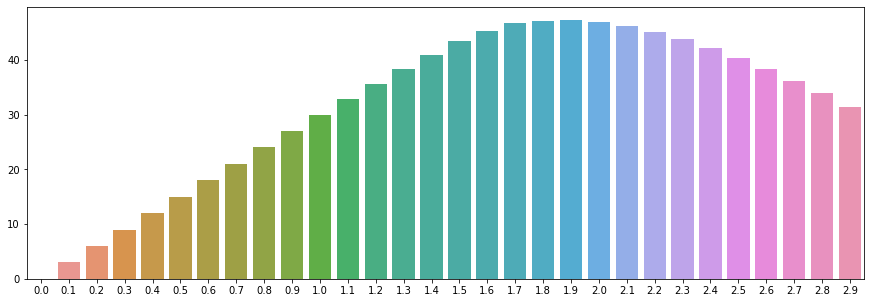

In [106]:
# Close, but something is probably missed in my rough estimate of the distribution from the ARIMA model
# What if the margin is better?
price = 2

mesh = np.arange(start=0, stop=3, step=0.1)

profits = []
for m in mesh:
    tmp_p = [get_profit(m, i) for i in test['ds_date']]
    profits.append(sum(tmp_p))

plt.figure(figsize=(15, 5))
sns.barplot(x=np.round(mesh, 1), y=profits)

In [107]:
# Optimal profit point?
mesh[profits.index(max(profits))]

1.9000000000000001

In [118]:
# This is just above our minimum points observed.  What is the theoretical solution?
# Demand ~ Normal(2, 0.478328)
critical_fractile = (price - cost) / price

# Get inverse normal of deman distribution
from scipy.stats import norm

norm.ppf(critical_fractile, loc=2, scale=0.478328)

2.0

In [119]:
# Still close!  